In [1]:
import pandas as pd
import numpy as np
import random
import pickle
import os, re, ast

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from itertools import combinations 
from sklearn.manifold import TSNE
#from bokeh.plotting import figure, show, output_notebook, save
#from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

from sklearn import preprocessing
from collections import OrderedDict
import sys
from scipy import spatial

from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

data_path = '/Users/amanda/Documents/Projects/insight/data/'

In [2]:
def convert_to_list(df,columns):
    """Convert columns in df back to lists from strings (this happens when saving to csv)
    """
    df.fillna('', inplace=True)

    for col in columns:
        if isinstance(df[col][0], str):
            df[col] = [ast.literal_eval(s) for s in df[col]]

    return df

In [3]:
# Load education and occupation details

jobs_df = pd.read_csv(os.path.join(data_path,'processed','jobbank-fields.csv'))
noc_overview_df = pd.read_csv(os.path.join(data_path,'processed','noc-overview.csv'))
details_df = pd.read_csv(os.path.join(data_path,'processed','job-description.csv'))
job_name_df = pd.read_csv(os.path.join(data_path,'processed','education-to-job.csv'))


In [6]:
job_name_df

,edu_level,education_groups,top_jobs,job_percent,top_job_links,link,identifier
0,College/CEGEP,Accounting,Accounting and related clerks,11.99,/marketreport/summary-occupation/14122/ca,/14122/ca,Accounting: College/CEGEP
1,College/CEGEP,Accounting,Financial auditors and accountants,11.23,/marketreport/summary-occupation/131/ca,/131/ca,Accounting: College/CEGEP
2,College/CEGEP,Accounting,Accounting technicians and bookkeepers,10.46,/marketreport/summary-occupation/24500/ca,/24500/ca,Accounting: College/CEGEP
3,College/CEGEP,Accounting,Administrative officers,3.92,/marketreport/summary-occupation/12462/ca,/12462/ca,Accounting: College/CEGEP
4,College/CEGEP,Accounting,Retail salespersons,3.25,/marketreport/summary-occupation/20599/ca,/20599/ca,Accounting: College/CEGEP
...,...,...,...,...,...,...,...
1935,Master's degree,Sociology,Administrative officers,2.63,/marketreport/summary-occupation/12462/ca,/12462/ca,Sociology: Master's degree
1936,Master's degree,Sociology,Social and community service workers,2.63,/marketreport/summary-occupation/5112/ca,/5112/ca,Sociology: Master's degree
1937,Master's degree,Sociology,Business development officers and marketing re...,2.63,/marketreport/summary-occupation/3916/ca,/3916/ca,Sociology: Master's degree
1938,Master's degree,Sociology,University professors and lecturers,1.97,/marketreport/summary-occupation/4707/ca,/4707/ca,Sociology: Master's degree


In [5]:
jobs_df['description'].str.split('found under ')
edu_categories = [s.split('found under ')[1] for s in jobs_df['description']]
edu_categories = [s.strip('.') for s in edu_categories]
jobs_df['education_groups'] = edu_categories

jobs_df = convert_to_list(jobs_df, ['top_jobs','top_job_links','job_percent'])

education_df = jobs_df[['degree','education_groups','top_jobs','job_percent']].drop_duplicates(subset =['education_groups','degree'])

job_name_df['noc'] = job_name_df['noc'].astype(str)
job_name_df['noc'] = [x.replace('.0','') for x in job_name_df['noc']]

details_df['noc'] = details_df['noc'].astype(str)
details_df['noc'] = [x.replace('.0','') for x in details_df['noc']]

noc_overview_df['noc'] = noc_overview_df['noc_code'].astype(str)
noc_overview_df['noc'] = [x.replace('.0','') for x in noc_overview_df['noc']]
noc_overview_df['job_group'] = [x.strip() for x in noc_overview_df['job_group']]

KeyError: 'noc'

In [67]:
merged_df = pd.merge(left=noc_overview_df[['job_group','noc']], 
                     right=details_df[['noc','description','duties']], 
                     how='left', 
                     left_on='noc', 
                     right_on='noc')

train_df = merged_df.drop_duplicates(subset =['job_group','noc'])
train_df = train_df.dropna()

train_df
    

,job_group,noc,description,duties
0,Legislators,11,Legislators participate in the activities of a...,"['Enact, amend or repeal laws and regulations'..."
1,Senior government managers and officials,12,"Senior government managers and officials plan,...",['Establish objectives for the organization in...
2,"Senior managers - financial, communications an...",13,"Senior managers in financial, communications a...","[""Determine the company's mission and strategi..."
3,"Senior managers - health, education, social an...",14,"Senior managers in health, education, social a...",['Establish objectives for the organization or...
4,"Senior managers - trade, broadcasting and othe...",15,"Senior managers in trade, broadcasting and oth...",['Establish objectives for the company and for...
5,"Senior managers - construction, transportation...",16,"Senior managers in construction, transportatio...",['Establish objectives for the company and for...
6,Financial managers,111,"Financial managers plan, organize, direct, con...","['Plan, organize, direct, control and evaluate..."
7,Human resources managers,112,"Human resources managers plan, organize, direc...","['Plan, organize, direct, control and evaluate..."
8,Purchasing managers,113,"Purchasing managers plan, organize, direct, co...","['Plan, organize, direct, control and evaluate..."
9,Other administrative services managers,114,"Other administrative services managers plan, o...","['Plan, organize, direct, control and evaluate..."


# Preprocessing text columns

In [68]:
def preprocess(text):
    """ preprocess text: remove special characters, remove digits, tokenize,
    lowercase, remove stopwords, lemmatize
    """
    # preparing for text preprocessing: tokenizer, stopwords, and lemmatizer
    tokenizer = RegexpTokenizer(r'\w+')
    stopwords_en = list(stopwords.words('english'))
    stopwords_en.extend(['work','works','worker','workers',
                         'activity','may','employed',
                         'company','companies',
                         'occupations','occupation','related'])
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens if len(token)>1]
    token_result = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en]

    return ' '.join(token_result)


In [69]:
# preprocess job title and description
for col in ['job_group','description','duties']:
    train_df[col] = train_df[col].astype(str)
    train_df[col+'_processed'] = train_df[col].apply(preprocess)

# have a column for both title and descritpion
cols = ['description_processed','duties_processed']
train_df['duties_and_desc'] = train_df[cols].apply(lambda x: ' '.join(x), axis=1)


In [70]:
def plot_common_words(df, column, n):
    """plot n most common words in a column of a df"""
    fdist = Counter(' '.join(row for row in df[column]).split()).most_common(n) # freq distribution of n most common words
    word = [i[0] for i in fdist]
    count = [i[1] for i in fdist]
    word_pos = [i for i, _ in enumerate(word)]
    
    plt.figure(figsize=(8, 6))
    plt.barh(word_pos, count)
    plt.yticks(word_pos, word)
    plt.ylabel('word')
    plt.xlabel('count')
    plt.title('Frequency of'+' '+str(n)+' '+'most common words in {}'.format(column))
    plt.gca().invert_yaxis() # invert y axis to descending order
    plt.show()

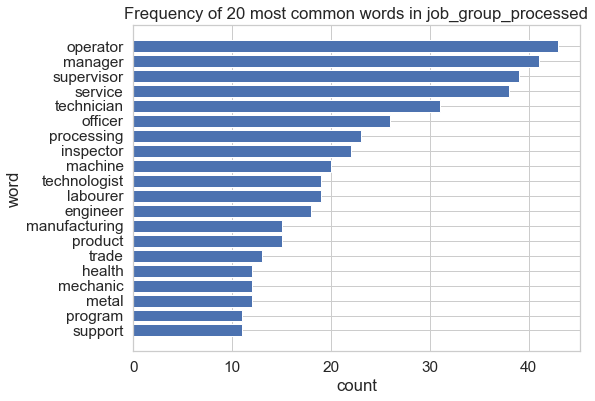

In [71]:
# plot most common words in job titles
sns.set(style='whitegrid', font_scale=1.4)
plot_common_words(train_df, 'job_group_processed', 20)

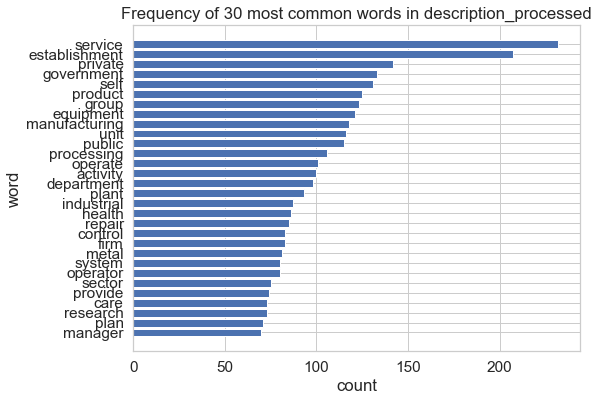

In [72]:
plot_common_words(train_df, 'description_processed', 30)

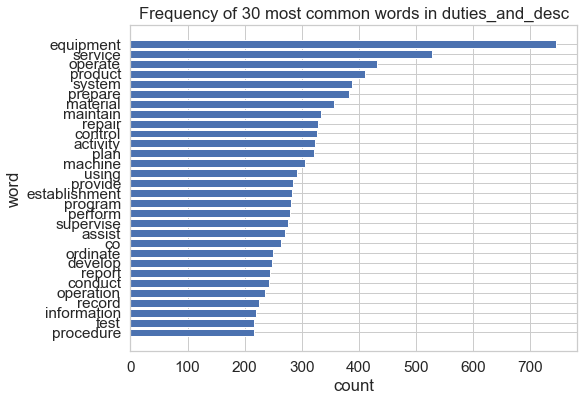

In [73]:
plot_common_words(train_df, 'duties_and_desc', 30)

In [121]:
# vectorize job description - for work_exp df
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=5000)
job_description_vec = vectorizer.fit_transform(train_df['duties_and_desc'])

In [122]:
def multiple_nmf(kmin, kmax, vec_text):
    """run multiple nmf models with a chosen range of number of components,
    return a list XXXXX
    
    kmin -- minimum number of topics
    kmax -- maximum number of topics
    vec_text -- vectorized text
    """
    topic_models = []
    for k in range(kmin, kmax+1):
        print("Applying NMF for k=%d ..." % k)
        nmf = NMF(n_components=k,
                  init="nndsvd",
                  alpha=0.1,
                  random_state=42) 
        W = nmf.fit_transform(vec_text)
        H = nmf.components_    
        topic_models.append((k, nmf, W, H))
    
    return topic_models

In [123]:
topic_models = multiple_nmf(10, 30, job_description_vec)

Applying NMF for k=10 ...
Applying NMF for k=11 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=12 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=28 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=29 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=30 ...


In [124]:
# convert job_description_processed to a list of lists for word2vec model
job_desc_train = train_df['duties_and_desc'].apply(lambda x: x.split(' ')).tolist()

# train word2vec model
word2vec_model = Word2Vec(job_desc_train,
                          size=200,
                          window=8,
                          min_count=5,
                          workers=4)

word2vec_model.train(job_desc_train, total_examples=len(job_desc_train), epochs=10)

(523621, 636840)

In [125]:
# have a look at the word2vec results
word2vec_model.wv.most_similar(positive='clean')

[('wash', 0.9491744041442871),
 ('unload', 0.9229450225830078),
 ('broken', 0.9225983619689941),
 ('remove', 0.9215736389160156),
 ('disinfect', 0.9192566275596619),
 ('load', 0.9084721207618713),
 ('otherwise', 0.90071702003479),
 ('feed', 0.8954201340675354),
 ('ice', 0.8930495977401733),
 ('trim', 0.8929161429405212)]

In [153]:
def get_top_terms(vectorizer, H, n_top_terms):
    """get terms most important for each of the topics of an nmf model
    return a dictionary with topic number as key and a list of top terms as values
    
    vectorizer -- vectorizer for text
    H -- topic term matrix from nmf model
    n_top_terms -- number of top words to choose
    """
    terms = vectorizer.get_feature_names()
    
    top_terms_dict = {};
    # for each topic, get the largest weights, and save the corresponding words into the dictionary
    num_topics = H.shape[0]
    for i in range(num_topics):
        ids = H[i].argsort()[-n_top_terms:] 
        # word_ids is ordered such that largest weight is the last item, reverse it to have it as first item
        top_terms_dict['Topic '+'{:01d}'.format(i+1)] = [terms[id] for id in reversed(ids)]
        
    return top_terms_dict

def compute_coherence(word2vec_model, top_terms_dict):
    """compute coherence score, ie, mean pairwise similarity of top terms
    
    word2vec_model -- word2vec model trained on words in dataset
    top_term_dict -- top words of each topic (output of get_top_terms() function)
    """
    overall_coherence = 0.0
    num_topics = len(top_terms_dict)
    for i in range(num_topics):
        pair_scores = []
        # compute similarity score for each pair of top words in each topic
        for pair in combinations(top_terms_dict['Topic '+'{:01d}'.format(i+1)], 2):
            try:
                pair_scores.append(word2vec_model.wv.similarity(pair[0], pair[1]))
            except:
                continue
        
        topic_score = sum(pair_scores)/len(pair_scores)
        overall_coherence += topic_score
    
    # get mean score across topics
    return overall_coherence/num_topics

def compare_coherence(topic_models, vectorizer, n_top_terms, word2vec_model):
    """get topic coherence for multiple nmf models
    
    topic_models -- output of multiple_nmf() function
    """
    coherence_dict = {}
    for i in range(len(topic_models)):
        top_terms_dict = get_top_terms(vectorizer, topic_models[i][3], n_top_terms) # 4th element of each list in topic_models: H     
        
        k = topic_models[i][0] # first element of each list in topic models: k
        coherence = compute_coherence(word2vec_model, top_terms_dict)
        print("K=%02d: Coherence=%.4f" % (k, coherence))
        coherence_dict[k] = coherence
        
    return coherence_dict

In [154]:
coherence_dict = compare_coherence(topic_models, vectorizer, 20, word2vec_model)

K=10: Coherence=0.6512
K=11: Coherence=0.6408
K=12: Coherence=0.6526
K=13: Coherence=0.6610
K=14: Coherence=0.6725
K=15: Coherence=0.6713
K=16: Coherence=0.6700
K=17: Coherence=0.6708
K=18: Coherence=0.6808
K=19: Coherence=0.6700
K=20: Coherence=0.6751
K=21: Coherence=0.6626
K=22: Coherence=0.6704
K=23: Coherence=0.6883
K=24: Coherence=0.6909
K=25: Coherence=0.6982
K=26: Coherence=0.6885
K=27: Coherence=0.6833
K=28: Coherence=0.6890
K=29: Coherence=0.6791
K=30: Coherence=0.6809


In [155]:
# get top words for each of 20 topics
best_k = 25
top_words = pd.DataFrame(get_top_terms(vectorizer, topic_models[best_k-10][3], 15))
W = topic_models[best_k-10][2]

In [156]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [157]:
# have a look at top words in each of the 20 topics
top_words

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25
0,co,financial,electrical,metal,patient,insurance,software,processing,construction,railway,food,film,well,social,court,wood,farm,student,animal,fishing,product,direct,aircraft,sport,tree
1,ordinate,senior,equipment,heavy,care,financial,information,plant,engineering,transport,beverage,television,gas,program,law,furniture,livestock,school,laboratory,fish,machine,organize,flight,fitness,forest
2,activity,manager,repair,machine,health,sale,system,process,design,passenger,patron,production,drilling,research,legal,fixture,crop,teacher,veterinarian,vessel,textile,plan,overhaul,event,logging
3,schedule,approve,test,sheet,medical,service,computer,chemical,project,truck,cook,video,oil,client,office,install,poultry,secondary,research,marine,garment,manager,vehicle,recreation,lawn
4,recommend,human,component,product,treatment,customer,data,pulp,building,operate,kitchen,picture,rig,health,officer,using,harvesting,college,conduct,navigational,fur,evaluate,air,athletic,site
5,supervise,resource,system,tool,nursing,credit,telecommunication,mineral,develop,cargo,restaurant,broadcast,drill,service,provincial,repair,agricultural,teach,technologist,seafood,leather,control,inspector,recreational,forestry
6,supervisor,middle,power,part,hospital,investment,network,equipment,engineer,equipment,bar,motion,service,community,administrative,surface,harvest,vocational,trap,crew,fabric,operation,inspect,athlete,landscape
7,contractor,policy,install,mineral,physician,account,develop,control,study,vehicle,chef,theatre,water,policy,document,building,breeding,elementary,veterinary,ship,operate,department,assembly,team,saw
8,requisition,formulate,electronic,machining,nurse,payment,technology,paper,survey,track,serve,radio,petroleum,conduct,property,wooden,general,teaching,chemical,gear,plastic,establishment,mechanic,professional,shrub
9,resolve,director,motor,boiler,disorder,good,application,machinery,conduct,locomotive,staff,camera,equipment,organization,judge,wall,pen,subject,assist,operate,manufacturing,service,mechanical,game,plant


In [146]:
# Initialize dictionary with descriptions for each topic
topic_dict = {'Topic1':'Supervisory activities',
              'Topic2':'HR & management',
              'Topic3':'Aviation & repair',
              'Topic4':'Machinery and manufacturing',
              'Topic5':'Healthcare',
              'Topic6':'Sales',
              'Topic7':'Information technology',
              'Topic8':'Chemistry',
              'Topic9':'Construction & civil engineering',
              'Topic10':'Rail & transportation',
              'Topic11':'Foodservice',
              'Topic12':'Media',
              'Topic13':'Mining and energy',
              'Topic14':'Electrical repair & installation',
              'Topic15':'Finance & banking',
              'Topic16':'Woodworking & repair',
              'Topic17':'Legal services & administration',
              'Topic18':'Education & public sevice',
              'Topic19':'Farming & agriculture',
              'Topic20':'Marine services'}

hobby_dict = {'Supervisory activities':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              'HR & management':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              'Aviation & repair':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              'Machinery and manufacturing':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              'Healthcare':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              'Sales':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              'Information technology':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              'Chemistry':[],
              'Construction & civil engineering':[],
              'Rail & transportation':[],
              'Foodservice':[],
              'Media':[],
              'Mining and energy':[],
              'Electrical repair & installation',
              'Finance & banking',
              'Woodworking & repair',
              'Legal services & administration',
              'Education & public sevice',
              'Farming & agriculture',
              'Marine services'}



In [131]:
# have a df for document topic matrix, merge with df_work
W = topic_models[best_k-10][2]

topic_weights = pd.DataFrame(W, columns=['Topic '+'{:01d}'.format(i+1) for i in range(best_k)])
topic_weights1 = pd.DataFrame.copy(topic_weights)
# normalize topic weights such that they sum to 1 for each ducoment/job description
topic_weights1 = topic_weights1.div(topic_weights1.sum(axis=1), axis=0)

# find top 3 topics for each document/job description
topic_weights1['highest_topic1'] = topic_weights.idxmax(axis=1)
topic_weights1['highest_topic2'] = topic_weights.T.apply(lambda x: x.nlargest(2).idxmin())
topic_weights1['highest_topic3'] = topic_weights.T.apply(lambda x: x.nlargest(3).idxmin())

df_work_train = pd.concat([train_df, topic_weights1], axis=1, sort=False)

In [132]:
df_work_train.head()

,job_group,noc,description,duties,job_group_processed,description_processed,duties_processed,duties_and_desc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,highest_topic1,highest_topic2,highest_topic3
0,Legislators,11,Legislators participate in the activities of a...,"['Enact, amend or repeal laws and regulations'...",legislator,legislator participate activity federal provin...,enact amend repeal law regulation participate ...,legislator participate activity federal provin...,0.000000,0.408240,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.376513,0.215247,0.0,0.00000,Topic 2,Topic 17,Topic 18
1,Senior government managers and officials,12,"Senior government managers and officials plan,...",['Establish objectives for the organization in...,senior government manager official,senior government manager official plan organi...,establish objective organization accordance go...,senior government manager official plan organi...,0.035771,0.758188,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.058231,0.000000,0.105094,0.042716,0.0,0.00000,Topic 2,Topic 17,Topic 15
2,"Senior managers - financial, communications an...",13,"Senior managers in financial, communications a...","[""Determine the company's mission and strategi...",senior manager financial communication busines...,senior manager financial communication busines...,determine mission strategic direction conveyed...,senior manager financial communication busines...,0.000000,0.723770,0.0,0.002197,0.000000,0.000000,0.0,0.010543,0.0,0.0,0.000000,0.006581,0.042465,0.0,0.200335,0.009188,0.000000,0.000000,0.0,0.00492,Topic 2,Topic 15,Topic 13
3,"Senior managers - health, education, social an...",14,"Senior managers in health, education, social a...",['Establish objectives for the organization or...,senior manager health education social communi...,senior manager health education social communi...,establish objective organization institution f...,senior manager health education social communi...,0.000000,0.695169,0.0,0.000000,0.040425,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.046648,0.000000,0.000000,0.217758,0.0,0.00000,Topic 2,Topic 18,Topic 15
4,"Senior managers - trade, broadcasting and othe...",15,"Senior managers in trade, broadcasting and oth...",['Establish objectives for the company and for...,senior manager trade broadcasting service,senior manager trade broadcasting customer ser...,establish objective formulate approve policy p...,senior manager trade broadcasting customer ser...,0.032605,0.678019,0.0,0.008124,0.000000,0.191349,0.0,0.000000,0.0,0.0,0.033286,0.022342,0.000000,0.0,0.034275,0.000000,0.000000,0.000000,0.0,0.00000,Topic 2,Topic 6,Topic 15


In [133]:
job_name_df.head()

,edu_level,education_groups,top_jobs,job_percent,top_job_links,link,identifier,noc
0,College/CEGEP,Accounting,Accounting and related clerks,11.99,/marketreport/summary-occupation/14122/ca,/14122/ca,Accounting: College/CEGEP,1431
1,College/CEGEP,Accounting,Financial auditors and accountants,11.23,/marketreport/summary-occupation/131/ca,/131/ca,Accounting: College/CEGEP,1111
2,College/CEGEP,Accounting,Accounting technicians and bookkeepers,10.46,/marketreport/summary-occupation/24500/ca,/24500/ca,Accounting: College/CEGEP,1311
3,College/CEGEP,Accounting,Administrative officers,3.92,/marketreport/summary-occupation/12462/ca,/12462/ca,Accounting: College/CEGEP,1221
4,College/CEGEP,Accounting,Retail salespersons,3.25,/marketreport/summary-occupation/20599/ca,/20599/ca,Accounting: College/CEGEP,6421


In [134]:
link_list = [i.split(';')[0] for i in job_name_df['top_job_links']]

job_name_df['top_job_links'] = link_list

In [135]:
def uniqueness(df1,df2,group):

    from scipy import spatial

    group_jobs = df1.where(df1['education_groups']==group).dropna().drop_duplicates(['top_jobs'])

    is_job = df2[df2.noc.isin(group_jobs['noc'])]

    not_job = df2[~df2.noc.isin(group_jobs['noc'].values)]
    #not_job = not_job.dropna(subset=['top_jobs'])

    job_mean = (is_job.iloc[:,-23:-3]).mean(axis = 0, skipna = True)

    results = []
    similarity = []
    for i in range(len(not_job)):
        b = not_job.iloc[i,-23:-3]
        c_sim = 1 - spatial.distance.cosine(job_mean, b)
        similarity.append(c_sim)

    not_job['similarity'] = similarity

    sorted_df = not_job.sort_values(by=['similarity'],ascending=False)

    results = sorted_df['job_group'][0:10]

    return list(results)
    

In [143]:
results = uniqueness(job_name_df,df_work_train,'Chemical engineering and related studies')

/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [144]:
results

['Industrial engineering and manufacturing technologists and technicians',
 'Architecture and science managers',
 'Home building and renovation managers',
 'Business development officers and marketing researchers and consultants',
 'Mining engineers',
 'Construction managers',
 'Geoscientists and oceanographers',
 'Physicists and astronomers',
 'Urban and land use planners',
 'Chemists']

In [91]:
len(df_work_train)

500

In [92]:
job_name_df.to_csv('/Users/amanda/Documents/Projects/insight/data/processed/model-1.csv', index=False)
df_work_train.to_csv('/Users/amanda/Documents/Projects/insight/data/processed/model-2.csv', index=False)







In [96]:
job_name_df.head()

,edu_level,education_groups,top_jobs,job_percent,top_job_links,link,identifier,noc
0,College/CEGEP,Accounting,Accounting and related clerks,11.99,/marketreport/summary-occupation/14122/ca,/14122/ca,Accounting: College/CEGEP,1431
1,College/CEGEP,Accounting,Financial auditors and accountants,11.23,/marketreport/summary-occupation/131/ca,/131/ca,Accounting: College/CEGEP,1111
2,College/CEGEP,Accounting,Accounting technicians and bookkeepers,10.46,/marketreport/summary-occupation/24500/ca,/24500/ca,Accounting: College/CEGEP,1311
3,College/CEGEP,Accounting,Administrative officers,3.92,/marketreport/summary-occupation/12462/ca,/12462/ca,Accounting: College/CEGEP,1221
4,College/CEGEP,Accounting,Retail salespersons,3.25,/marketreport/summary-occupation/20599/ca,/20599/ca,Accounting: College/CEGEP,6421


In [95]:
df_work_train.head()

,job_group,noc,description,duties,job_group_processed,description_processed,duties_processed,duties_and_desc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,highest_topic1,highest_topic2,highest_topic3
0,Legislators,11,Legislators participate in the activities of a...,"['Enact, amend or repeal laws and regulations'...",legislator,legislator participate activity federal provin...,enact amend repeal law regulation participate ...,legislator participate activity federal provin...,0.000000,0.408240,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.376513,0.215247,0.0,0.00000,Topic 2,Topic 17,Topic 18
1,Senior government managers and officials,12,"Senior government managers and officials plan,...",['Establish objectives for the organization in...,senior government manager official,senior government manager official plan organi...,establish objective organization accordance go...,senior government manager official plan organi...,0.035771,0.758188,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.058231,0.000000,0.105094,0.042716,0.0,0.00000,Topic 2,Topic 17,Topic 15
2,"Senior managers - financial, communications an...",13,"Senior managers in financial, communications a...","[""Determine the company's mission and strategi...",senior manager financial communication busines...,senior manager financial communication busines...,determine mission strategic direction conveyed...,senior manager financial communication busines...,0.000000,0.723770,0.0,0.002197,0.000000,0.000000,0.0,0.010543,0.0,0.0,0.000000,0.006581,0.042465,0.0,0.200335,0.009188,0.000000,0.000000,0.0,0.00492,Topic 2,Topic 15,Topic 13
3,"Senior managers - health, education, social an...",14,"Senior managers in health, education, social a...",['Establish objectives for the organization or...,senior manager health education social communi...,senior manager health education social communi...,establish objective organization institution f...,senior manager health education social communi...,0.000000,0.695169,0.0,0.000000,0.040425,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.046648,0.000000,0.000000,0.217758,0.0,0.00000,Topic 2,Topic 18,Topic 15
4,"Senior managers - trade, broadcasting and othe...",15,"Senior managers in trade, broadcasting and oth...",['Establish objectives for the company and for...,senior manager trade broadcasting service,senior manager trade broadcasting customer ser...,establish objective formulate approve policy p...,senior manager trade broadcasting customer ser...,0.032605,0.678019,0.0,0.008124,0.000000,0.191349,0.0,0.000000,0.0,0.0,0.033286,0.022342,0.000000,0.0,0.034275,0.000000,0.000000,0.000000,0.0,0.00000,Topic 2,Topic 6,Topic 15


In [160]:
# reduce 25-d to 2-d for visualization of topics
# tsne with 2 components
tsne = TSNE(n_components=2, random_state=42)
tsne_nmf = tsne.fit_transform(W)



In [161]:
df_work_train['tsne1'] = tsne_nmf[:, 0]
df_work_train['tsne2'] = tsne_nmf[:, 1]

# summary of highest topic: use top 5 words from each topic (each column in nmf_topics df)
df_work_train['topic_sum'] = df_work_train.highest_topic1.apply(lambda x: x + ': ' + ', '.join(top_words.loc[:, x][:5]))



In [162]:
# color mapping for most important topic
topics = ['Topic '+'{:01d}'.format(i+1) for i in range(20)]
colors = ['#ffcc33', '#ff9999', '#ff3333', '#ff9900', '#cc99cc',
          '#996600', '#cc6666', '#cc0033', '#99ccff', '#660066',
          '#336600', '#003366', '#ffff00', '#ccff00', '#999999',
          '#93cbbd', '#0000cc', '#9966cc', '#3399cc', '#ffccff']
color_dict = dict(zip(topics, colors))
df_work_train['color'] = df_work_train.highest_topic1.apply(lambda x: color_dict[x])



In [166]:
# change psych df to bokeh data structure
source = ColumnDataSource(df_work_train)

title = 'T-SNE visualization of topics in descriptions of work experience'

plot_nmf = figure(plot_width=1000, plot_height=800, title=title,
                  tools="pan,wheel_zoom,box_zoom,reset,hover",
                  x_axis_type=None, y_axis_type=None, min_border=1)

plot_nmf.scatter(x='tsne1', y='tsne2', source=source,
                 color='color', alpha=0.6, size=4)

# for i in range(norm_features.shape[1]):
#     plot_nmf.text(topic_coord[i, 0], topic_coord[i, 1], [we['topic_sum'][i]])

# hover tools - display title, agency of each job post
hover = plot_nmf.select(dict(type=HoverTool))
hover.tooltips = {"Work experience": "Title: @job_title_processed"}

show(plot_nmf)